In [53]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import tifffile
from einops import rearrange, repeat

In [54]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [55]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
%autoreload 2

In [57]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom

In [58]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'export')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [59]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [60]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [61]:
exclude = ['S18-25943-A7', 'C3L-00970', 'WD-76845']

In [62]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_25res/config.yaml$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_25res/co

In [63]:
case_to_sections = {fp.split('/')[-3]:yaml.safe_load(open(fp))['sections'] for fp in fps}
case_to_sections = {k:v for k, v in case_to_sections.items() if k not in exclude}
case_to_sections.keys()

dict_keys(['C3L-00982', 'C3L-01287', 'C3L-02551', 'HT206B1', 'HT225C1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT413C1-K2', 'HT413C1-Th1k4A1', 'HT448C1-Th1K1Fp1', 'HT553P1-H2', 'HT565B1-H2', 'S18-5591-C8', 'S18-9906', 'P21_F2RM6R'])

In [64]:
# case = 'HT206B1'
case = 'HT413C1-Th1k4A1'

In [65]:
sections = case_to_sections[case]
sections

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s0_HT413C1-Th1k4A1-U14_he.tif'}],
  'position': 0,
  'sid': 'HT413C1-Th1k4A1-U14'},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s1_HT413C1-Th1k4A1-U18_he.tif'}],
  'position': 20,
  'sid': 'HT413C1-Th1k4A1-U18'},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s2_HT413C1-Th1k4A1-U19_xenium.h5ad'}],
  'position': 25,
  'sid': 'HT413C1-Th1k4A1-U19'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s3_HT413C1-Th1k4A1-U20_multiplex.ome.tiff'}],
  'position': 30,
  'sid': 'HT413C1-Th1k4A1-U20'},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s4_HT413C1-Th1k4A1-U1_h

In [66]:
dtype_to_volume = pickle.load(
    open(os.path.join(project_dir, case, 'mushroom_25res', f'nbhd_volumes_l2.pkl'), 'rb')
)['labeled']

outputs = pickle.load(
    open(os.path.join(project_dir, case, 'mushroom_25res', f'outputs.pkl'), 'rb')
)
section_ids = outputs['section_ids']
section_positions = outputs['section_positions']
section_ids, section_positions

([('HT413C1-Th1k4A1-U14', 'he'),
  ('HT413C1-Th1k4A1-U18', 'he'),
  ('HT413C1-Th1k4A1-U19', 'xenium'),
  ('HT413C1-Th1k4A1-U20', 'multiplex'),
  ('HT413C1-Th1k4A1-U1', 'he'),
  ('HT413C1-Th1k4A1-U2', 'xenium'),
  ('HT413C1-Th1k4A1-U3', 'multiplex'),
  ('HT413C1-Th1k4A1-U4', 'he'),
  ('HT413C1-Th1k4A1-U7', 'cosmx'),
  ('HT413C1-Th1k4A1-U8', 'he'),
  ('HT413C1-Th1k4A1-U9', 'xenium'),
  ('HT413C1-Th1k4A1-U11', 'he'),
  ('HT413C1-Th1k4A1-U21', 'he'),
  ('HT413C1-Th1k4A1-U24', 'he'),
  ('HT413C1-Th1k4A1-U25', 'xenium'),
  ('HT413C1-Th1k4A1-U26', 'multiplex'),
  ('HT413C1-Th1k4A1-U27', 'he'),
  ('HT413C1-Th1k4A1-U29', 'he'),
  ('HT413C1-Th1k4A1-U30', 'he'),
  ('HT413C1-Th1k4A1-U32', 'multiplex'),
  ('HT413C1-Th1k4A1-U34', 'cosmx'),
  ('HT413C1-Th1k4A1-U35', 'he'),
  ('HT413C1-Th1k4A1-U36', 'xenium'),
  ('HT413C1-Th1k4A1-U37', 'multiplex'),
  ('HT413C1-Th1k4A1-U38', 'he'),
  ('HT413C1-Th1k4A1-U40', 'he'),
  ('HT413C1-Th1k4A1-U41', 'multiplex'),
  ('HT413C1-Th1k4A1-U42', 'multiplex')],
 array(

In [67]:
mushroom = Mushroom.from_config(
    os.path.join(project_dir, case, 'mushroom_25res'), accelerator='cpu'
)

INFO:root:loading spore for cosmx
INFO:root:data mask detected
INFO:root:starting cosmx processing
INFO:root:using 1000 channels
INFO:root:2 sections detected: ['HT413C1-Th1k4A1-U7', 'HT413C1-Th1k4A1-U34']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U7
INFO:root:generating image data for section HT413C1-Th1k4A1-U34


cosmx torch.Size([1000, 204, 146])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT413C1-Th1k4A1-U7', 'cosmx'), ('HT413C1-Th1k4A1-U34', 'cosmx')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_25res/cosmx_chkpts/last-v1.ckpt
INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:14 sections detected: ['HT413C1-Th1k4A1-U14', 'HT413C1-Th1k4A1-U18', 'HT413C1-Th1k4A1-U1', 'HT413C1-Th1k4A1-U4', 'HT413C1-Th1k4A1-U8', 'HT413C1-Th1k

0.04


INFO:root:generating image data for section HT413C1-Th1k4A1-U1
INFO:root:generating image data for section HT413C1-Th1k4A1-U4
INFO:root:generating image data for section HT413C1-Th1k4A1-U8
INFO:root:generating image data for section HT413C1-Th1k4A1-U11
INFO:root:generating image data for section HT413C1-Th1k4A1-U21
INFO:root:generating image data for section HT413C1-Th1k4A1-U24
INFO:root:generating image data for section HT413C1-Th1k4A1-U27
INFO:root:generating image data for section HT413C1-Th1k4A1-U29
INFO:root:generating image data for section HT413C1-Th1k4A1-U30
INFO:root:generating image data for section HT413C1-Th1k4A1-U35
INFO:root:generating image data for section HT413C1-Th1k4A1-U38
INFO:root:generating image data for section HT413C1-Th1k4A1-U40
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 14 sections detected: [('HT413C1-Th1k4A1-U14', 'he'), ('HT413C1-Th1k4A1-U18', 'he'), ('HT413C1-Th1k4A1-U1', 'he'), ('HT413C1-Th1k4A1-U4', '

he torch.Size([3, 203, 145])
0.04


INFO:root:generating image data for section HT413C1-Th1k4A1-U3
INFO:root:generating image data for section HT413C1-Th1k4A1-U26
INFO:root:generating image data for section HT413C1-Th1k4A1-U32
INFO:root:generating image data for section HT413C1-Th1k4A1-U37
INFO:root:generating image data for section HT413C1-Th1k4A1-U41
INFO:root:generating image data for section HT413C1-Th1k4A1-U42
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 7 sections detected: [('HT413C1-Th1k4A1-U20', 'multiplex'), ('HT413C1-Th1k4A1-U3', 'multiplex'), ('HT413C1-Th1k4A1-U26', 'multiplex'), ('HT413C1-Th1k4A1-U32', 'multiplex'), ('HT413C1-Th1k4A1-U37', 'multiplex'), ('HT413C1-Th1k4A1-U41', 'multiplex'), ('HT413C1-Th1k4A1-U42', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPU

multiplex torch.Size([27, 203, 145])


INFO:root:using 477 channels
INFO:root:5 sections detected: ['HT413C1-Th1k4A1-U19', 'HT413C1-Th1k4A1-U2', 'HT413C1-Th1k4A1-U9', 'HT413C1-Th1k4A1-U25', 'HT413C1-Th1k4A1-U36']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U19
INFO:root:generating image data for section HT413C1-Th1k4A1-U2
INFO:root:generating image data for section HT413C1-Th1k4A1-U9
INFO:root:generating image data for section HT413C1-Th1k4A1-U25
INFO:root:generating image data for section HT413C1-Th1k4A1-U36


xenium torch.Size([477, 204, 146])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 5 sections detected: [('HT413C1-Th1k4A1-U19', 'xenium'), ('HT413C1-Th1k4A1-U2', 'xenium'), ('HT413C1-Th1k4A1-U9', 'xenium'), ('HT413C1-Th1k4A1-U25', 'xenium'), ('HT413C1-Th1k4A1-U36', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_25res/xenium_chkpts/last-v1.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding cosmx spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-p

Predicting: |                                                                                                 …

INFO:root:embedding he spore


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

In [68]:
outputs = pickle.load(
    open(os.path.join(project_dir, case, 'mushroom_25res', f'outputs.pkl'), 'rb')
)
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [69]:
dtype = 'xenium'
spore = mushroom.dtype_to_spore[dtype]
combined = None
for sid, a in spore.learner_data.dtype_to_section_to_adata[dtype].items():
    for level in range(mushroom.num_levels):
        pts = a.obsm['spatial']
        labels = mushroom.assign_pts(pts, (sid, dtype), dtype, level=level)
        a.obs[f'nbhd_{dtype}_level{level}'] = [f'nbhd {x}' for x in labels]
        
        dtype_to_volume = pickle.load(
            open(os.path.join(project_dir, case, 'mushroom_25res', f'nbhd_volumes_l{level}.pkl'), 'rb')
        )['labeled']
        
        labels = mushroom.assign_pts(pts, (sid, dtype), dtype, level=level, use_volume=True, volume=dtype_to_volume['integrated'])
        a.obs[f'nbhd_integrated_level{level}'] = [f'nbhd {x}' for x in labels]
        
        labels = mushroom.assign_pts(pts, (sid, dtype), dtype, level=level, use_volume=True, volume=dtype_to_volume['multiplex'])
        a.obs[f'nbhd_multiplex_level{level}'] = [f'nbhd {x}' for x in labels]
    df = a.obs[[x for x in a.obs.columns if 'nbhd' in x]]
    df['sid'] = sid
    df.index = [f'{sid}-{x}' for x in df.index.to_list()]
    
    if combined is None:
        combined = df
    else:
        combined = pd.concat((combined, df))
combined
        

/tmp/ipykernel_3957571/2250139842.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs[f'nbhd_{dtype}_level{level}'] = [f'nbhd {x}' for x in labels]
/tmp/ipykernel_3957571/2250139842.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sid'] = sid
/tmp/ipykernel_3957571/2250139842.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs[f'nbhd_{dtype}_level{level}'] = [f'nbhd {x}' for x in labels]
/tmp/ipykernel_3957571/2250139842.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,nbhd_xenium_level0,nbhd_integrated_level0,nbhd_multiplex_level0,nbhd_xenium_level1,nbhd_integrated_level1,nbhd_multiplex_level1,nbhd_xenium_level2,nbhd_integrated_level2,nbhd_multiplex_level2,sid
HT413C1-Th1k4A1-U19-aaaaahcn-1,nbhd 4,nbhd 3,nbhd 6,nbhd 12,nbhd 8,nbhd 15,nbhd 19,nbhd 12,nbhd 25,HT413C1-Th1k4A1-U19
HT413C1-Th1k4A1-U19-aaaaibcn-1,nbhd 4,nbhd 3,nbhd 6,nbhd 12,nbhd 8,nbhd 15,nbhd 19,nbhd 12,nbhd 25,HT413C1-Th1k4A1-U19
HT413C1-Th1k4A1-U19-aaabchmf-1,nbhd 4,nbhd 3,nbhd 6,nbhd 12,nbhd 8,nbhd 15,nbhd 19,nbhd 12,nbhd 25,HT413C1-Th1k4A1-U19
HT413C1-Th1k4A1-U19-aaacfenh-1,nbhd 2,nbhd 1,nbhd 6,nbhd 5,nbhd 23,nbhd 15,nbhd 9,nbhd 25,nbhd 25,HT413C1-Th1k4A1-U19
HT413C1-Th1k4A1-U19-aaachjof-1,nbhd 0,nbhd 0,nbhd 0,nbhd 2,nbhd 2,nbhd 1,nbhd 4,nbhd 23,nbhd 2,HT413C1-Th1k4A1-U19
...,...,...,...,...,...,...,...,...,...,...
HT413C1-Th1k4A1-U36-oilbbedb-1,nbhd 4,nbhd 27,nbhd 0,nbhd 11,nbhd 6,nbhd 1,nbhd 18,nbhd 5,nbhd 2,HT413C1-Th1k4A1-U36
HT413C1-Th1k4A1-U36-oilbldfc-1,nbhd 2,nbhd 29,nbhd 4,nbhd 6,nbhd 25,nbhd 12,nbhd 11,nbhd 15,nbhd 20,HT413C1-Th1k4A1-U36
HT413C1-Th1k4A1-U36-oilblnpd-1,nbhd 4,nbhd 27,nbhd 0,nbhd 11,nbhd 6,nbhd 1,nbhd 18,nbhd 5,nbhd 2,HT413C1-Th1k4A1-U36
HT413C1-Th1k4A1-U36-oilbplcp-1,nbhd 2,nbhd 29,nbhd 4,nbhd 6,nbhd 25,nbhd 12,nbhd 11,nbhd 15,nbhd 20,HT413C1-Th1k4A1-U36


In [70]:
dtype_to_exp = mushroom.calculate_cluster_intensities(level=2, projection_dtype='xenium')
dtype_to_exp.keys()

dict_keys(['cosmx', 'he', 'multiplex', 'xenium'])

In [71]:
dtype_to_exp['xenium']

,ABCC11,ACAN,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,...,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VIM,VPREB1,VSIG4,VWA5A,VWF
0,0.092037,1.164776,0.148148,0.257282,1.900426,1.316208,1.216087,1.802644,0.369036,1.849486,...,0.654098,0.159549,0.133260,1.709583,0.859991,2.412656,0.224971,0.912604,0.910590,1.217610
1,0.062991,1.002774,0.076663,0.209446,1.792102,0.893858,1.115117,1.777966,0.281979,1.535568,...,0.655235,0.074408,0.092390,1.776977,0.388958,2.224240,0.142018,0.928547,0.556301,1.178731
2,0.123191,0.348437,0.379885,0.372724,0.567874,1.311980,0.553245,0.536251,0.439665,0.709827,...,0.425242,0.276231,0.219524,0.550392,1.353562,0.970233,0.318544,0.401366,0.762401,0.473719
3,0.066435,0.114167,0.234953,0.275418,0.393947,0.754582,0.361792,0.316615,0.344724,0.308667,...,0.337640,0.169722,0.104973,0.462780,0.791647,0.643125,0.214182,0.314190,0.406956,0.275308
4,0.109500,0.422677,0.166755,0.224329,0.911794,0.688123,0.632910,0.953578,0.262159,0.775052,...,0.450235,0.133315,0.093617,0.919931,0.479965,1.265155,0.149231,0.625216,0.412620,0.703665
5,-0.004752,0.610826,0.027960,0.152314,1.396103,0.355262,0.830799,1.288271,0.178625,0.939644,...,0.585521,0.046945,0.041440,1.560887,0.015555,1.754203,0.062915,0.709691,0.242304,0.820815
6,0.654052,0.234971,0.535140,-0.025775,-0.166455,0.456624,-0.100963,0.808729,0.032708,0.558125,...,-0.363662,0.013693,0.101522,-0.910730,0.331944,-0.007670,-0.031382,0.538649,0.484596,0.622169
7,0.537661,0.443457,0.261168,0.046222,0.332241,0.087606,0.329643,1.281211,0.110592,0.843799,...,-0.095204,0.064502,-0.064133,-0.124334,-0.046168,0.449589,0.005779,0.867426,0.163908,0.930139
8,0.097861,-0.075813,0.068184,0.090350,0.133200,0.083810,0.100396,0.225835,0.098267,0.023283,...,0.152970,0.015428,0.012289,0.207682,0.059525,0.228718,0.045750,0.269883,0.010039,0.177591
9,0.083894,-0.095042,0.038578,0.082651,0.210082,0.036083,0.123687,0.177340,0.111103,-0.035536,...,0.255769,0.004941,-0.001849,0.424789,-0.019148,0.323459,0.038586,0.273488,-0.018523,0.115588


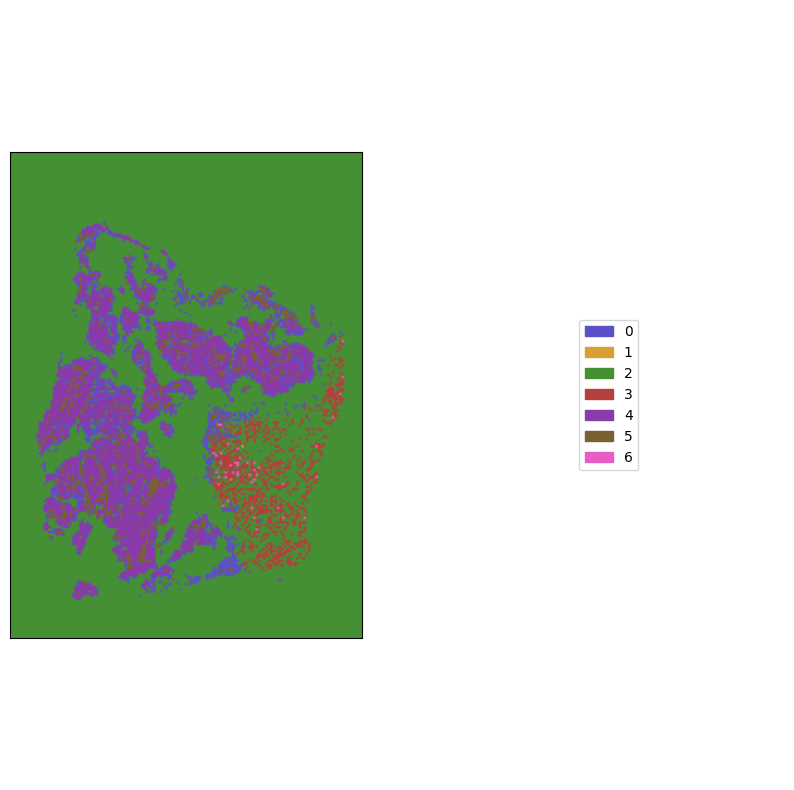

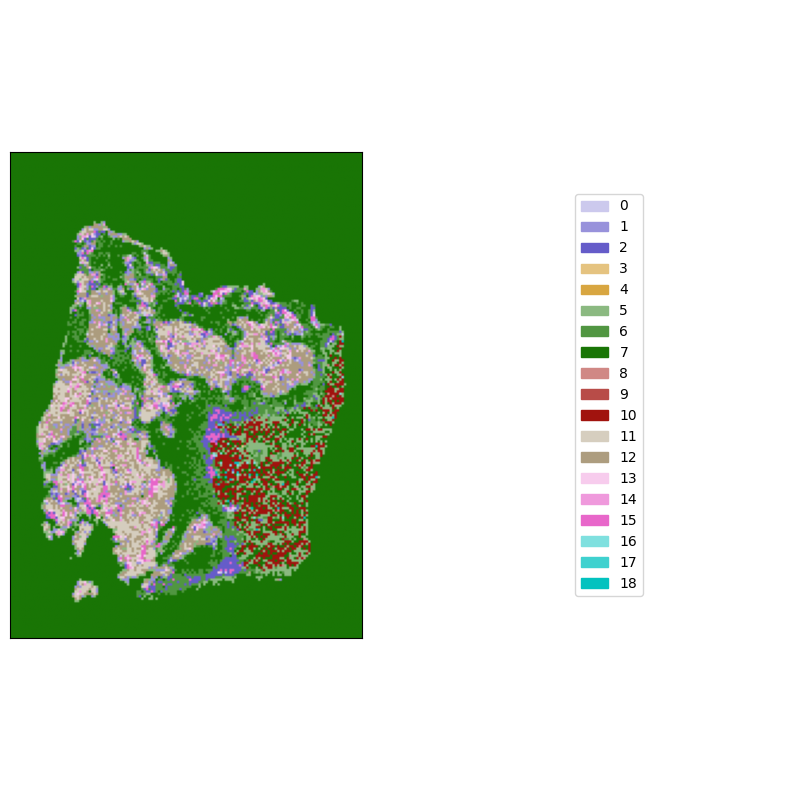

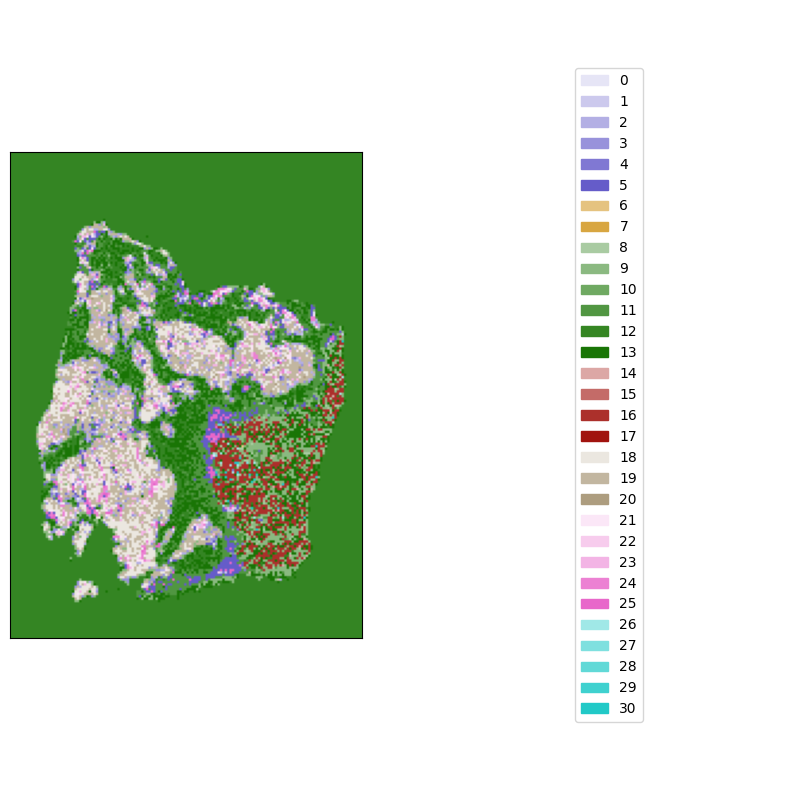

In [72]:
for i in range(mushroom.num_levels):
    mushroom.display_clusters('xenium', section_idxs=[0], level=i, figsize=(10, 10))
    plt.show()

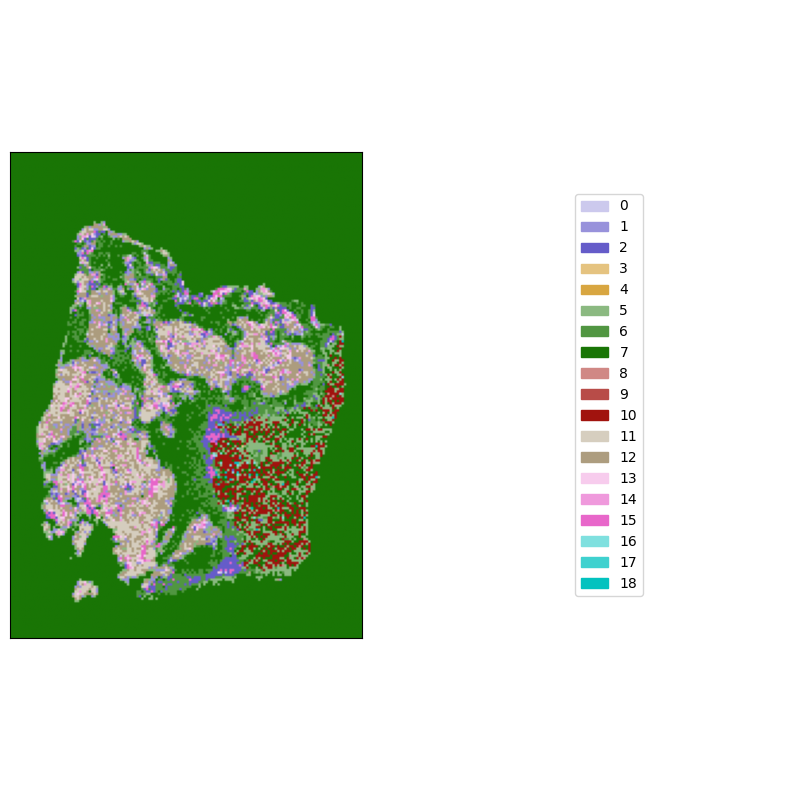

In [73]:
mushroom.display_clusters('xenium', section_idxs=[0], level=1, figsize=(10, 10))

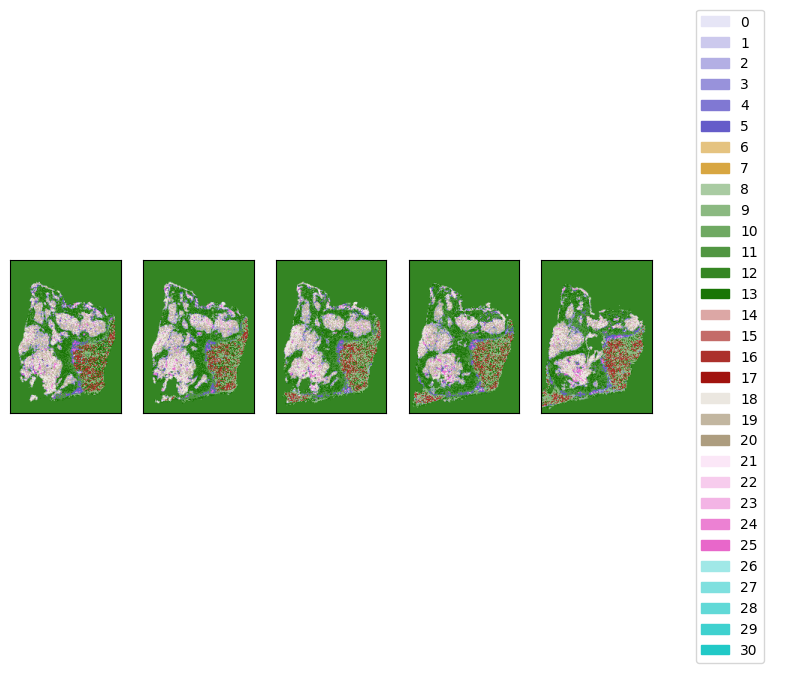

In [74]:
mushroom.display_clusters('xenium', level=2)

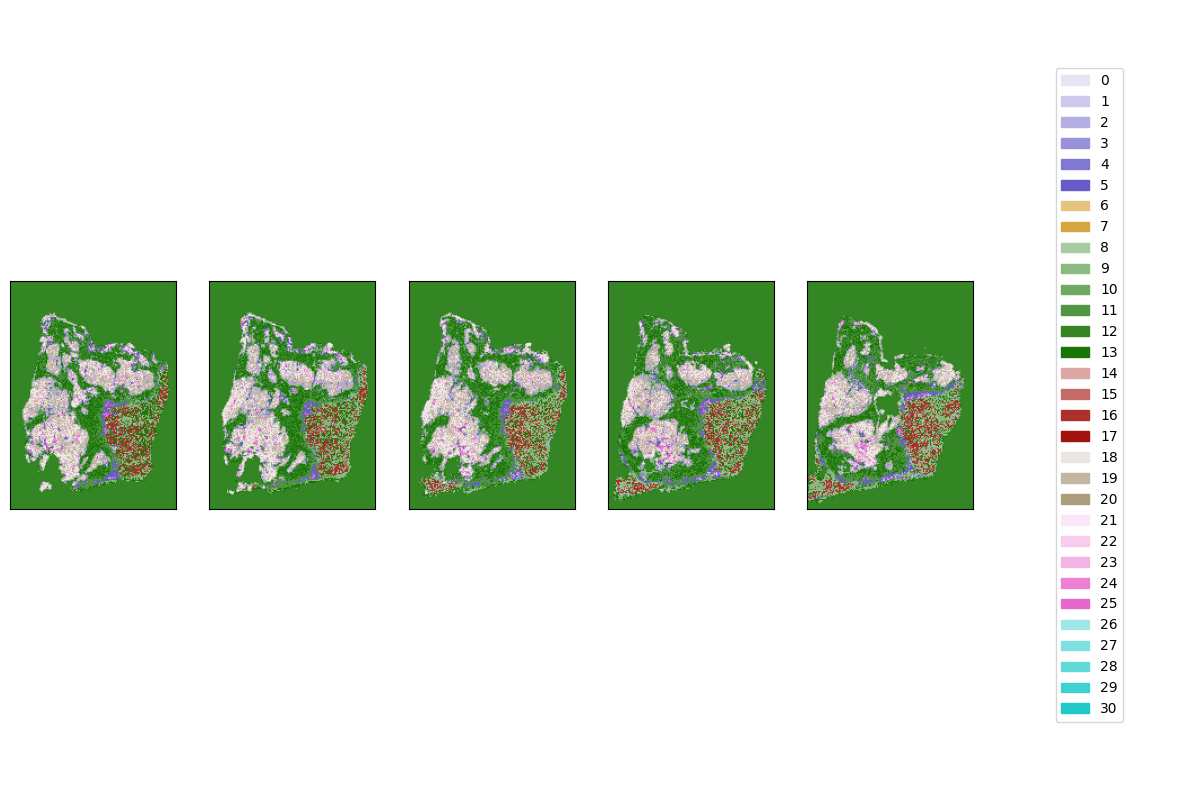

In [75]:
mushroom.display_clusters('xenium', level=2, figsize=(15, 10))

Text(0.5, 23.52222222222222, 'blah')

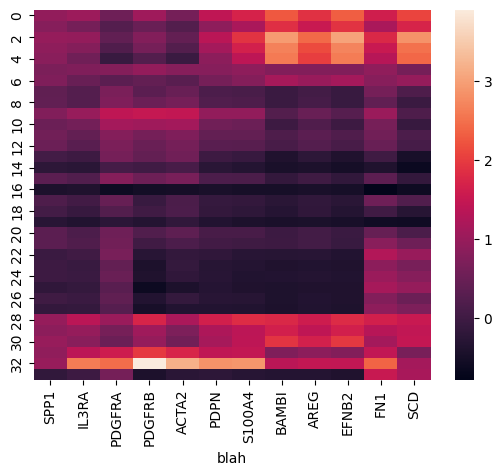

In [28]:
genes = [
    'SPP1',
    'IL3RA',
    'PDGFRA',
    'PDGFRB',
    'ACTA2',
    'PDPN',
    'S100A4',
    'BAMBI',
    'AREG',
    'EFNB2',
    'FN1',
    'SCD'
]
df = dtype_to_exp['xenium'][genes]
sns.heatmap(df)
plt.gca().set_xlabel('blah')

In [47]:
def get_nbhd_rgb(dtype='xenium', nbhds=None, cmap=None):
    labeled = dtype_to_volume[dtype][0]

    rgb = vis_utils.display_labeled_as_rgb(
        labeled, preserve_indices=True, label_to_hierarchy=outputs['dtype_to_cluster_to_agg'][dtype][2])
    
    if nbhds is not None:
        m = np.zeros_like(labeled, dtype=bool)
        for l in nbhds:
            m |= labeled==l

        rgb[~m] = 0.
    
    return rgb



def get_intensity_img(case, dtype, gene):
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
    )
    
    channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
    true_pixels = true_pixels[0]
    
    img = true_pixels[..., channels.index(gene)]
    
    return img


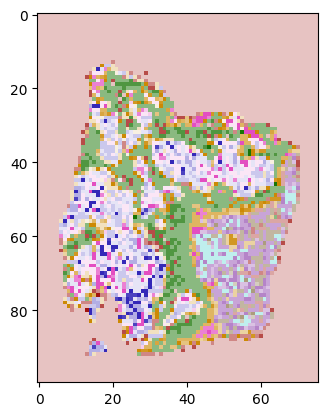

In [48]:
rgb = get_nbhd_rgb()
plt.imshow(rgb)

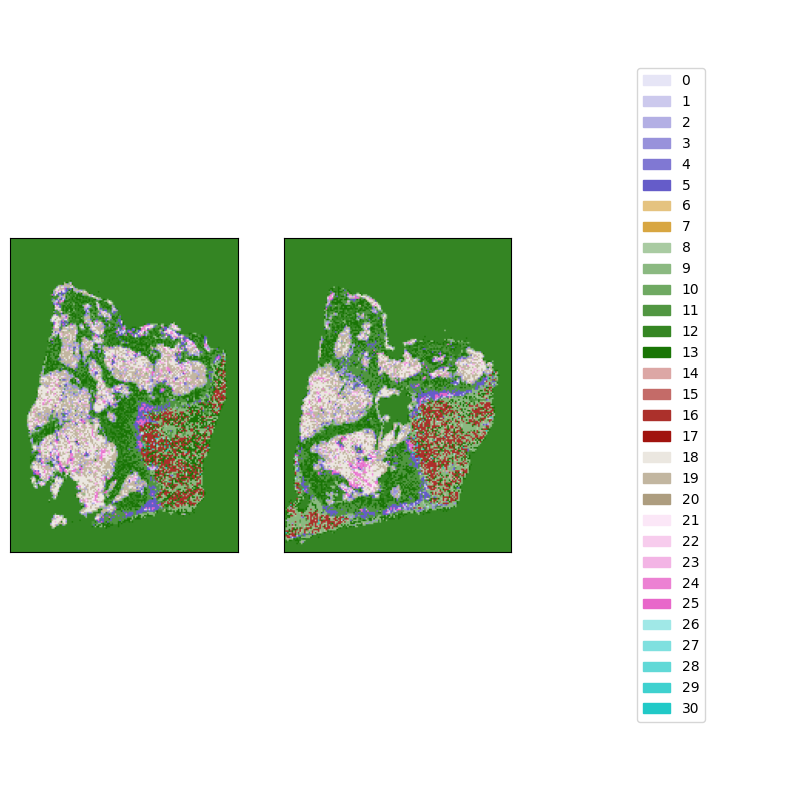

In [101]:
mushroom.display_clusters('xenium', section_idxs=[0, -1], level=2, figsize=(10, 10))

In [88]:
dtype_to_exp = mushroom.calculate_cluster_intensities(level=2, projection_dtype='xenium')
df = dtype_to_exp['xenium']
df

,ABCC11,ACAN,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,...,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VIM,VPREB1,VSIG4,VWA5A,VWF
0,0.092037,1.164776,0.148148,0.257282,1.900426,1.316208,1.216087,1.802644,0.369036,1.849486,...,0.654098,0.159549,0.133260,1.709583,0.859991,2.412656,0.224971,0.912604,0.910590,1.217610
1,0.062991,1.002774,0.076663,0.209446,1.792102,0.893858,1.115117,1.777966,0.281979,1.535568,...,0.655235,0.074408,0.092390,1.776977,0.388958,2.224240,0.142018,0.928547,0.556301,1.178731
2,0.123191,0.348437,0.379885,0.372724,0.567874,1.311980,0.553245,0.536251,0.439665,0.709827,...,0.425242,0.276231,0.219524,0.550392,1.353562,0.970233,0.318544,0.401366,0.762401,0.473719
3,0.066435,0.114167,0.234953,0.275418,0.393947,0.754582,0.361792,0.316615,0.344724,0.308667,...,0.337640,0.169722,0.104973,0.462780,0.791647,0.643125,0.214182,0.314190,0.406956,0.275308
4,0.109500,0.422677,0.166755,0.224329,0.911794,0.688123,0.632910,0.953578,0.262159,0.775052,...,0.450235,0.133315,0.093617,0.919931,0.479965,1.265155,0.149231,0.625216,0.412620,0.703665
5,-0.004752,0.610826,0.027960,0.152314,1.396103,0.355262,0.830799,1.288271,0.178625,0.939644,...,0.585521,0.046945,0.041440,1.560887,0.015555,1.754203,0.062915,0.709691,0.242304,0.820815
6,0.654052,0.234971,0.535140,-0.025775,-0.166455,0.456624,-0.100963,0.808729,0.032708,0.558125,...,-0.363662,0.013693,0.101522,-0.910730,0.331944,-0.007670,-0.031382,0.538649,0.484596,0.622169
7,0.537661,0.443457,0.261168,0.046222,0.332241,0.087606,0.329643,1.281211,0.110592,0.843799,...,-0.095204,0.064502,-0.064133,-0.124334,-0.046168,0.449589,0.005779,0.867426,0.163908,0.930139
8,0.097861,-0.075813,0.068184,0.090350,0.133200,0.083810,0.100396,0.225835,0.098267,0.023283,...,0.152970,0.015428,0.012289,0.207682,0.059525,0.228718,0.045750,0.269883,0.010039,0.177591
9,0.083894,-0.095042,0.038578,0.082651,0.210082,0.036083,0.123687,0.177340,0.111103,-0.035536,...,0.255769,0.004941,-0.001849,0.424789,-0.019148,0.323459,0.038586,0.273488,-0.018523,0.115588


In [99]:
genes = [
    'FN1', 'CD68', 'IL7R', 'EFNB2', 'SCD', 'AREG', 'BAMBI', 'SPP1'
]
df.sort_values(['FN1'])[genes]

,FN1,CD68,IL7R,EFNB2,SCD,AREG,BAMBI,SPP1
12,-0.606947,-0.333247,-0.276261,-0.453134,-0.505877,-0.390029,-0.463412,-0.280208
13,0.038744,-0.144265,0.068853,-0.384370,-0.229337,-0.278229,-0.388968,-0.084259
11,0.324139,0.105499,0.638582,-0.334734,-0.279087,-0.137512,-0.323981,0.139022
9,0.390804,0.147139,0.289938,-0.166888,0.099821,-0.016053,-0.086851,0.215590
17,0.458021,0.035504,0.075237,-0.288414,0.194954,-0.179465,-0.227151,0.057506
8,0.570944,0.191025,0.215321,-0.122528,0.311389,-0.016104,-0.042992,0.217125
3,0.786911,0.496351,0.410373,0.656363,0.709901,0.555738,0.740597,0.520267
14,0.855309,0.255619,0.189786,-0.137411,0.575883,-0.041530,-0.062791,0.227927
5,0.869913,0.539927,1.175282,0.048698,-0.022029,0.185601,-0.046163,0.422192
20,0.921135,0.582342,0.290570,0.933076,1.038600,0.737263,1.028039,0.519173


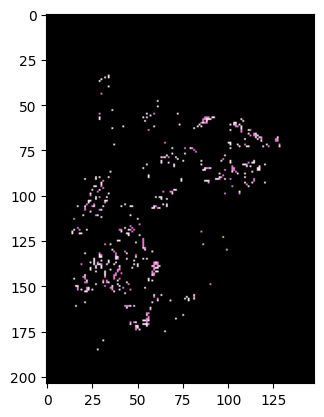

In [80]:
rgb = get_nbhd_rgb(nbhds=[24,6,7, 21, 27])
plt.imshow(rgb)

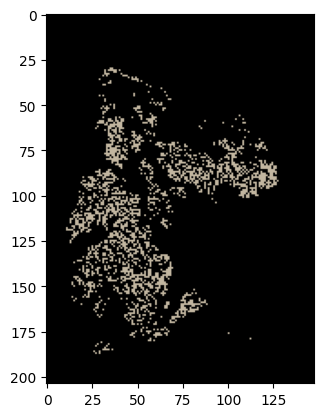

In [95]:
rgb = get_nbhd_rgb(nbhds=[19])
plt.imshow(rgb)

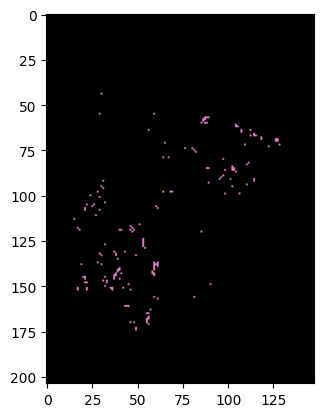

In [92]:
rgb = get_nbhd_rgb(nbhds=[24])
plt.imshow(rgb)

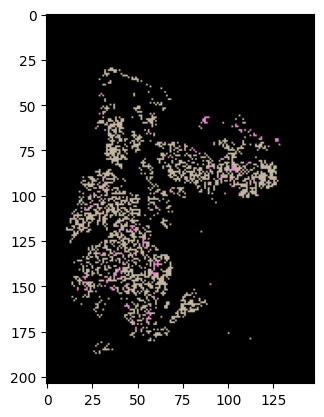

In [100]:
rgb = get_nbhd_rgb(nbhds=[24, 19])
plt.imshow(rgb)

In [82]:
genes = [
    'SCD'
]
df.sort_values(['SCD'])[genes]

,SCD
12,-0.505877
11,-0.279087
13,-0.229337
5,-0.022029
25,-0.016399
9,0.099821
17,0.194954
8,0.311389
1,0.441781
22,0.502020
